In [1]:
import os

#import matplotlib
#matplotlib.use('MACOSX')
#for some reason if I run these 2 lines - it doesnt plot at all any more.

import numpy as np
import mne
import matplotlib.pyplot as plt
from copy import deepcopy
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

In [2]:
#sample_data_folder = mne.datasets.sample.data_path()
#kath_raw_file2 = "/Users/jenya/Documents/Oldenburg and university/Job Uni Rieger lab/Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif"
kath_raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')
print(kath_raw_file)
#print(kath_raw_file2)                                   
raw = mne.io.read_raw_fif(kath_raw_file)
#raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

#Print info about the data:
print(raw)
print(raw.info)
raw

Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif
Opening raw data file Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-2.fif...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_67560/2609755721.py:6: RuntimeWarning: This filename (Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(kath_raw_file)


    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 3376000 ... 4942999 =   3376.000 ...  4942.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-3.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 

<Raw | mikado-1.fif, 319 x 3390000 (3390.0 s), ~6.6 MB, data not loaded>

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)


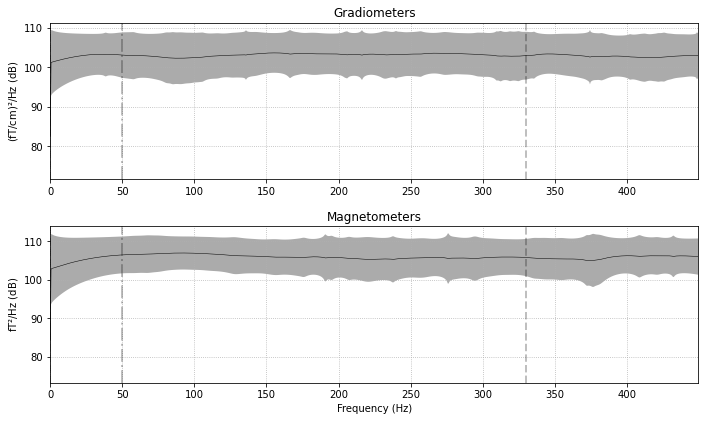

In [3]:
#%% Frequency spectrum and marking power line noise (NO MULTITAPERS):

# https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.plot_psd
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html

fig = raw.plot_psd(tmax=np.inf, fmax=450, average=True, picks=['mag', 'grad'])
#plot_psd can already identify magnetometers and gradiometers!

#if we got epochs which we dont:
#epochs.plot_psd(fmin=2., fmax=40., average=True, spatial_colors=False)

# add some arrows at 60 Hz and its harmonics:
powerline_freq_eu=50
powerline_freq_us=60
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (powerline_freq_eu, powerline_freq_eu*2, powerline_freq_eu*3, powerline_freq_eu*4):
    #for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)


# https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py

    Using multitaper spectrum estimation with 7 DPSS windows


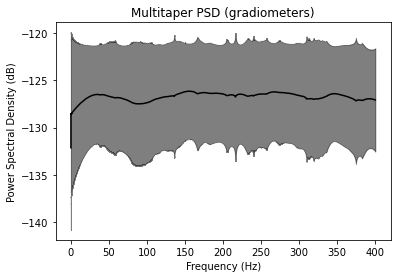

    Using multitaper spectrum estimation with 7 DPSS windows


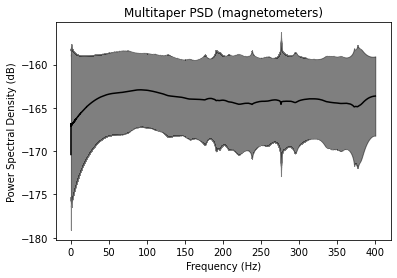

Time to calculate and plot with multitapers:  518.0180132389069


In [4]:
# %% Using MULTITAPER: takes around 8 min, while plot_psd is faster...
# But I dont know what windows plot_psd is using for frequency separation and also it does not 
# give frequencies and amplitudes as a separate variable, just the plot.

original_raw = raw.copy() #just in case. need to check what changes the data and what doesnt

#Time how long it takes to calculate:
import time
t0 = time.time()

#frequency spectrum only for gradiometers:
picks_grad = mne.pick_types(raw.info, meg='grad', eeg=False, eog=True, stim=False)
picks_magn = mne.pick_types(raw.info, meg='mag', eeg=False, eog=True, stim=False)
picks_=[picks_grad, picks_magn]

for n_pick, p in enumerate(picks_):

       f, ax = plt.subplots()
       #psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1)
       psds, freqs = psd_multitaper(original_raw, fmin=0, fmax=400, n_jobs=1, picks=picks_[n_pick]) #picks=picks_grad)
       psds = 10 * np.log10(psds)  # convert to dB. (from tutorial, we might not need this?)
       psds_mean = psds.mean(0)
       psds_std = psds.std(0)

       #if we got epochs instead of whole data set:
       #psds_mean = psds.mean(0).mean(0)
       #psds_std = psds.mean(0).std(0)

       ax.plot(freqs, psds_mean, color='k')
       ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)

       if n_pick==0:
              tit='Multitaper PSD (gradiometers)'
       elif n_pick==1:
              tit='Multitaper PSD (magnetometers)'

       ax.set(title=tit, xlabel='Frequency (Hz)',
              ylabel='Power Spectral Density (dB)')
       plt.show()

t1 = time.time()
total_time_mult = t1-t0

print('Time to calculate and plot with multitapers: ', total_time_mult)

#I dont see peaks at the power line frequencies.

In [5]:
# BANDWIDTH CHANGE HERE:
# Change width of freq. Bands.  Then freq with strong power are very visible. 
# Look at wide and narrow bands.
#ISSUE: if i change the bandwidth to any number, it calculates forever with no result.

for n_pick, p in enumerate(picks_):

       f, ax = plt.subplots()
       #psds, freqs = psd_multitaper(epochs, fmin=2, fmax=40, n_jobs=1)
       psds, freqs = psd_multitaper(original_raw, fmin=0, fmax=400, n_jobs=1, picks=picks_[n_pick], bandwidth=3)
       #bandwidth=..(float) The bandwidth of the multi taper windowing function in Hz. 
       # The default value is a window half-bandwidth of 4.
       
       psds = 10 * np.log10(psds)  # convert to dB
       psds_mean = psds.mean(0)
       psds_std = psds.std(0)

       #if we got epochs instead of whole data set:
       #psds_mean = psds.mean(0).mean(0)
       #psds_std = psds.mean(0).std(0)

       ax.plot(freqs, psds_mean, color='k')
       ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)

       if n_pick==0:
              tit='Multitaper PSD (gradiometers)'
       elif n_pick==1:
              tit='Multitaper PSD (magnetometers)'

       ax.set(title=tit, xlabel='Frequency (Hz)',
              ylabel='Power Spectral Density (dB)')
       plt.show()